In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
sys.path.insert(0, '../../../rb_utils/')
sys.path.insert(0, '../../rb_utils/')
import common_utils 

In [22]:
np.random.seed(43534)
_ = torch.manual_seed(901)


# Load data

In [23]:
data_dir = './mnist_data/'
propn_sample = 0.01

In [24]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [25]:
batchsize = 10

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [26]:
len(train_loader.dataset)

600

In [27]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [28]:
slen = data_train['image'].shape[-1]

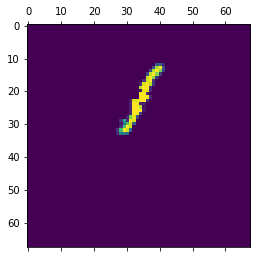

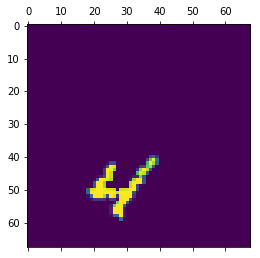

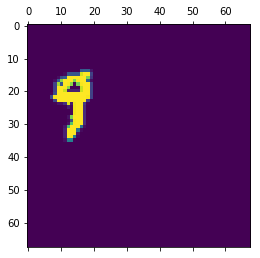

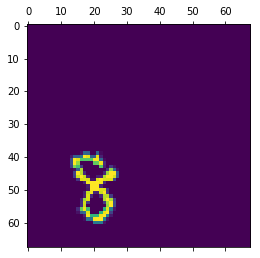

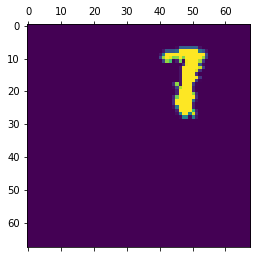

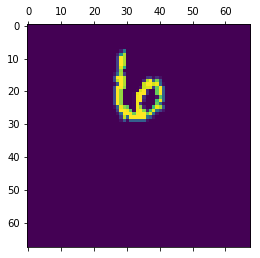

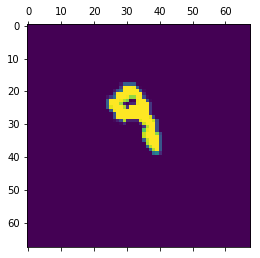

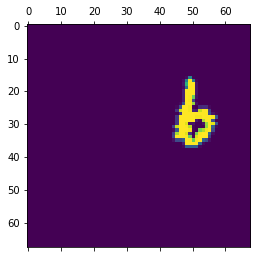

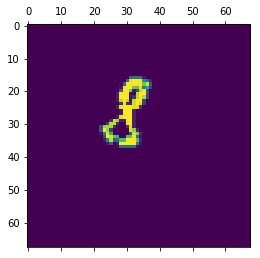

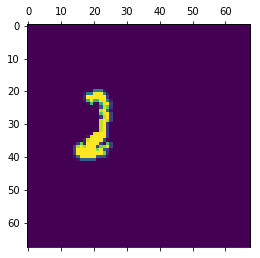

In [29]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [30]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [31]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [32]:
vae_file = './mnist_vae_results/moving_mnist_vae_reinforce_doublebs_topk5_final'
# vae_file = './mnist_vae_results/moving_mnist_vae_nsamples6_epoch80'

moving_mnist_vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

moving_mnist_vae.eval()

MovingHandwritingVAE(
  (mnist_vae): HandwritingVAE(
    (encoder): MLPEncoder(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=10, bias=True)
      (tanh): Tanh()
    )
    (decoder): MLPDecoder(
      (fc1): Linear(in_features=5, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=784, bias=True)
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
  )
  (pixel_attention): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
    )
    (fc1): Linear(in_features=3600, out_features=4624, bias=True)
    (log_softmax): LogSoftmax()
  )
)

# Check losses

In [33]:
# train_loss = vae_training_lib.eval_vae(moving_mnist_vae, train_loader, 
#                             grad_estimator = None, 
#                             train = False,
#                             set_true_loc = False)

# print(train_loss)

In [34]:
# images_debugging = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6images_debugging.npy')
# images_debugging = torch.Tensor(images_debugging)

In [35]:
# moving_mnist_vae.get_rb_loss(images_debugging, n_samples = 0)[1] / images_debugging.shape[0]

# Check reconstructions 

In [36]:
use_images_debugging = False
if use_images_debugging: 
    image = images_debugging

In [37]:
log_pixel_probs = moving_mnist_vae.pixel_attention(image)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa2114a4fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa2114b08d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa2114a4e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa21148c160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa21148c588>],
 'means': []}

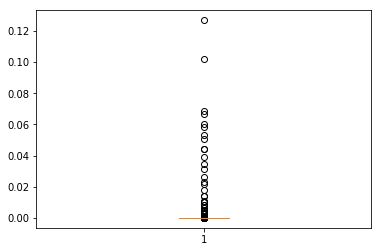

In [38]:
plt.boxplot(torch.exp(log_pixel_probs[6, :].detach()))

In [39]:
map_pixel_1d = torch.argmax(log_pixel_probs, dim=1)

In [40]:
use_true_loc = True
if use_true_loc: 
    map_pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)

pixel_one_hot = common_utils.get_one_hot_encoding_from_int(map_pixel_1d, slen**2)
recon_means = moving_mnist_vae.forward_cond_pixel_1d(pixel_one_hot, image)[0]

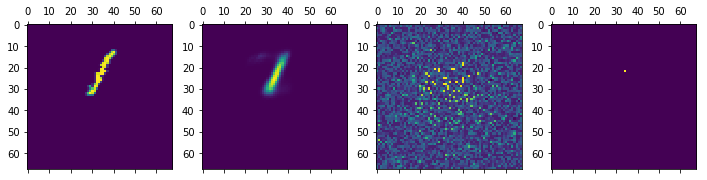

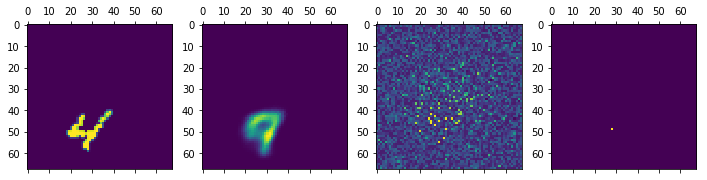

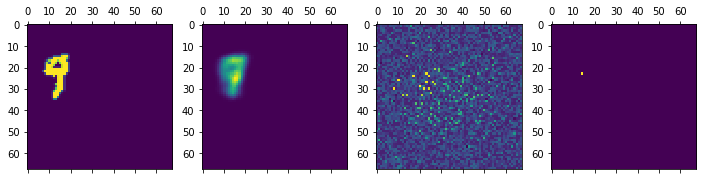

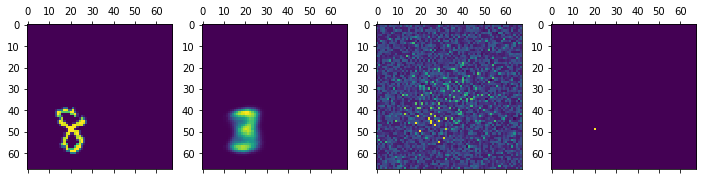

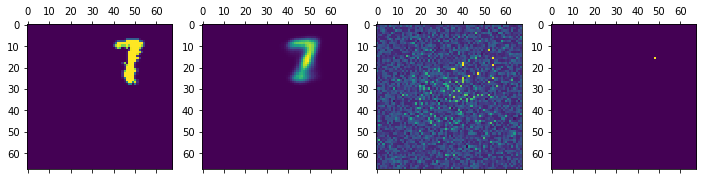

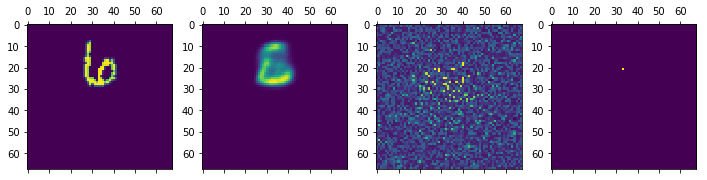

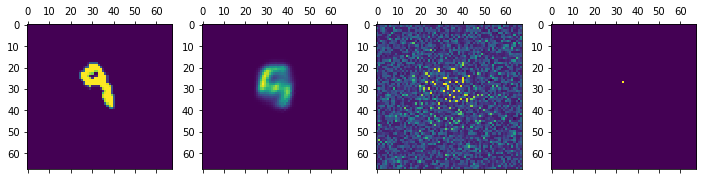

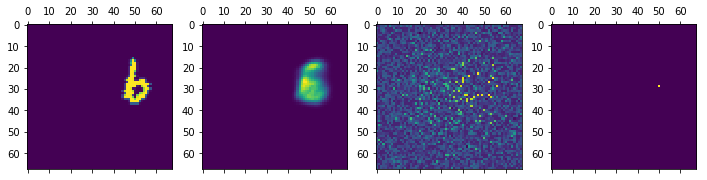

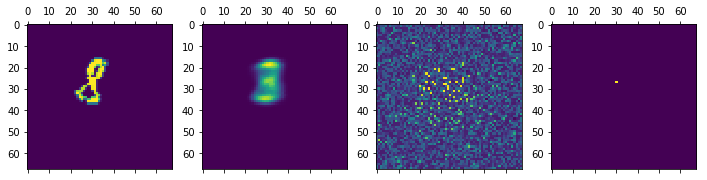

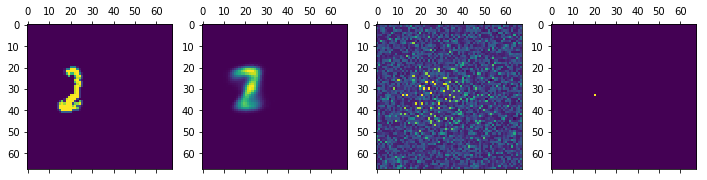

In [41]:
# printing the map locations 
loc_plots = torch.zeros(recon_means.shape)
map_pixel_2d = mnist_data_utils.pixel_1d_to_2d(sout = 68, padding = 0, pixel_1d = map_pixel_1d)

for i in range(0, 10): 
    
    _, axarr = plt.subplots(1, 4, figsize=(12, 12))
    
    # image and reconstruction 
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(recon_means[i, 0, :, :].detach())
    
    # location distributions 
    axarr[2].matshow(log_pixel_probs[i, :].view(68, 68).detach())
    
    # map location 
    loc_plots[i, 0, map_pixel_2d[i, 1], map_pixel_2d[i, 0]] = 1
    axarr[3].matshow(loc_plots[i, 0, :, :])

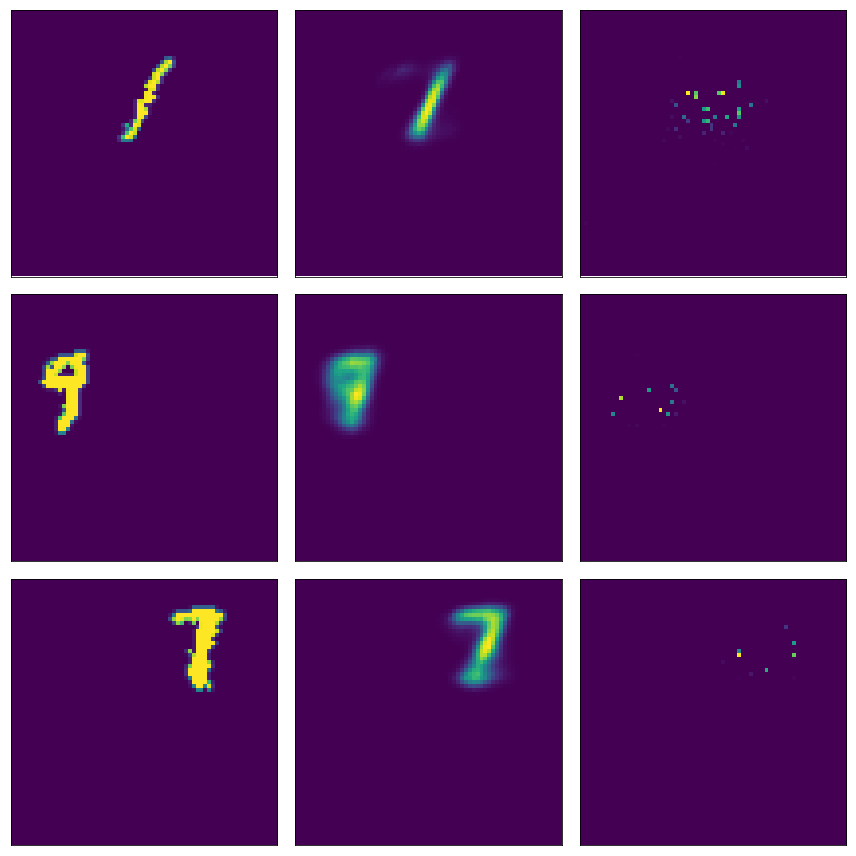

In [43]:
# figure for paper

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))

which_indx = [0, 2, 4]
for i in range(0, 3): 
    
    # image and reconstruction 
    axarr[i, 0].matshow(image[which_indx[i], 0, :, :])
    axarr[i, 0].get_xaxis().set_visible(False)
    axarr[i, 0].get_yaxis().set_visible(False)

    axarr[i, 1].matshow(recon_means[which_indx[i], 0, :, :].detach())
    axarr[i, 1].get_xaxis().set_visible(False)
    axarr[i, 1].get_yaxis().set_visible(False)

    
    # location distributions 
    foo = axarr[i, 2].matshow(np.exp(log_pixel_probs[which_indx[i], :].view(68, 68).detach()))
    axarr[i, 2].get_xaxis().set_visible(False)
    axarr[i, 2].get_yaxis().set_visible(False)

    
# fig.colorbar(foo, ax=axarr[0, 2])
# fig.colorbar(foo, ax=axarr[1, 2])
# fig.colorbar(foo, ax=axarr[2, 2])

    
    # map location 
#     loc_plots[i, 0, map_pixel_2d[i, 1], map_pixel_2d[i, 0]] = 1
#     axarr[3].matshow(loc_plots[i, 0, :, :])

plt.tight_layout()

fig.savefig('../icml_figures/moving_mnist_reconstructions.png')

In [53]:
batch_losses_rb = np.load('./mnist_vae_results/moving_mnist_vae_topk5_batch_losses.npy')

In [40]:
batch_losses_resample = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_batch_losses.npy')

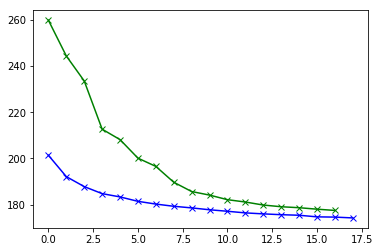

In [46]:
plt.plot(batch_losses_rb[3:-1], 'b-x'); 
plt.plot(batch_losses_resample[3:-1], 'g-x');

In [42]:
batch_losses_resample

array([2260.776  ,  629.4944 ,  351.22852,  259.74808,  244.29407,
        233.50844,  212.66417,  208.15678,  200.14632,  196.57947,
        189.73183,  185.71513,  184.1761 ,  182.19484,  181.18123,
        179.88263,  179.14665,  178.72667,  178.09306,  177.54758,
        177.1628 ], dtype=float32)

In [43]:
test_losses = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_test_losses.npy')

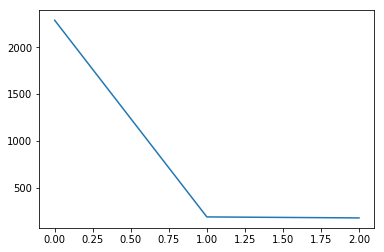

In [44]:
plt.plot(test_losses)

In [72]:
foo = torch.rand(5)

In [73]:
foo2 = torch.rand(5, 1)

In [74]:
foo - foo2

tensor([[ 0.4372, -0.1649,  0.2577,  0.3256, -0.1115],
        [ 0.4360, -0.1661,  0.2564,  0.3244, -0.1128],
        [ 0.7005,  0.0984,  0.5210,  0.5889,  0.1518],
        [ 0.4608, -0.1413,  0.2813,  0.3492, -0.0879],
        [ 0.4448, -0.1573,  0.2652,  0.3332, -0.1039]])